# Analyse Exploratoire - Features SPY LSTM

Ce notebook analyse les features techniques et leur impact sur la prédiction des rendements SPY.<br>
https://www.toolify.ai/fr/ai-new-fr/prdictions-boursires-via-lstm-conseils-et-piges-3545919 


In [ ]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Configuration
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

# Chargement des données (définition globale)
data_path = "/Users/eagle/DevTools/sentinel/data/dataset/3-features/spy_features.parquet"
df = pd.read_parquet(data_path)
df['DATE'] = pd.to_datetime(df['DATE'])
df = df.sort_values('DATE').reset_index(drop=True)

print(f"Données chargées: {len(df)} lignes")
print(f"Période: {df['DATE'].min()} à {df['DATE'].max()}")
print(f"Colonnes: {list(df.columns)}")


In [1]:
# Vérification et chargement automatique de df
if 'df' not in locals():
    print("⚠️ df n'est pas défini, rechargement automatique...")
    # Import nécessaire
    import pandas as pd
    # Rechargement des données
    data_path = "/Users/eagle/DevTools/sentinel/data/dataset/3-features/spy_features.parquet"
    df = pd.read_parquet(data_path)
    df['DATE'] = pd.to_datetime(df['DATE'])
    df = df.sort_values('DATE').reset_index(drop=True)
    print(f"✅ DataFrame df rechargé: {len(df)} lignes, {len(df.columns)} colonnes")
else:
    print(f"✅ DataFrame df disponible: {len(df)} lignes, {len(df.columns)} colonnes")

print(f"✅ Colonnes: {list(df.columns)[:5]}...")  # Afficher les 5 premières colonnes


⚠️ df n'est pas défini, rechargement automatique...
✅ DataFrame df rechargé: 6720 lignes, 19 colonnes
✅ Colonnes: ['TICKER', 'DATE', 'Open', 'High', 'Low']...


In [ ]:
# Calcul des rendements 
import numpy as np  # Import nécessaire pour cette cellule

df['returns'] = df['Close'].pct_change()
df['log_returns'] = np.log(df['Close'] / df['Close'].shift(1))
df['future_returns'] = df['returns'].shift(-1)
df['future_direction'] = (df['future_returns'] > 0).astype(int)

# Nettoyage
df = df.dropna() # suppression des valeurs manquantes

print(f"Données après nettoyage: {len(df)} lignes")


Données après nettoyage: 6686 lignes


## 1. Analyse des Rendements


In [ ]:
# Statistiques des rendements
print("Statistiques des rendements:")
print(df['returns'].describe())

# Test de stationnarité
from statsmodels.tsa.stattools import adfuller
adf_result = adfuller(df['returns'].dropna())
print(f"\nTest ADF - p-value: {adf_result[1]:.6f}") # p-value: 0.000000
print(f"Stationnaire: {'Oui' if adf_result[1] < 0.05 else 'Non'}") # Stationnaire: Oui


Statistiques des rendements:
count    6686.000000
mean        0.000395
std         0.012221
min        -0.109424
25%        -0.004726
50%         0.000681
75%         0.006092
max         0.145198
Name: returns, dtype: float64

Test ADF - p-value: 0.000000
Stationnaire: Oui


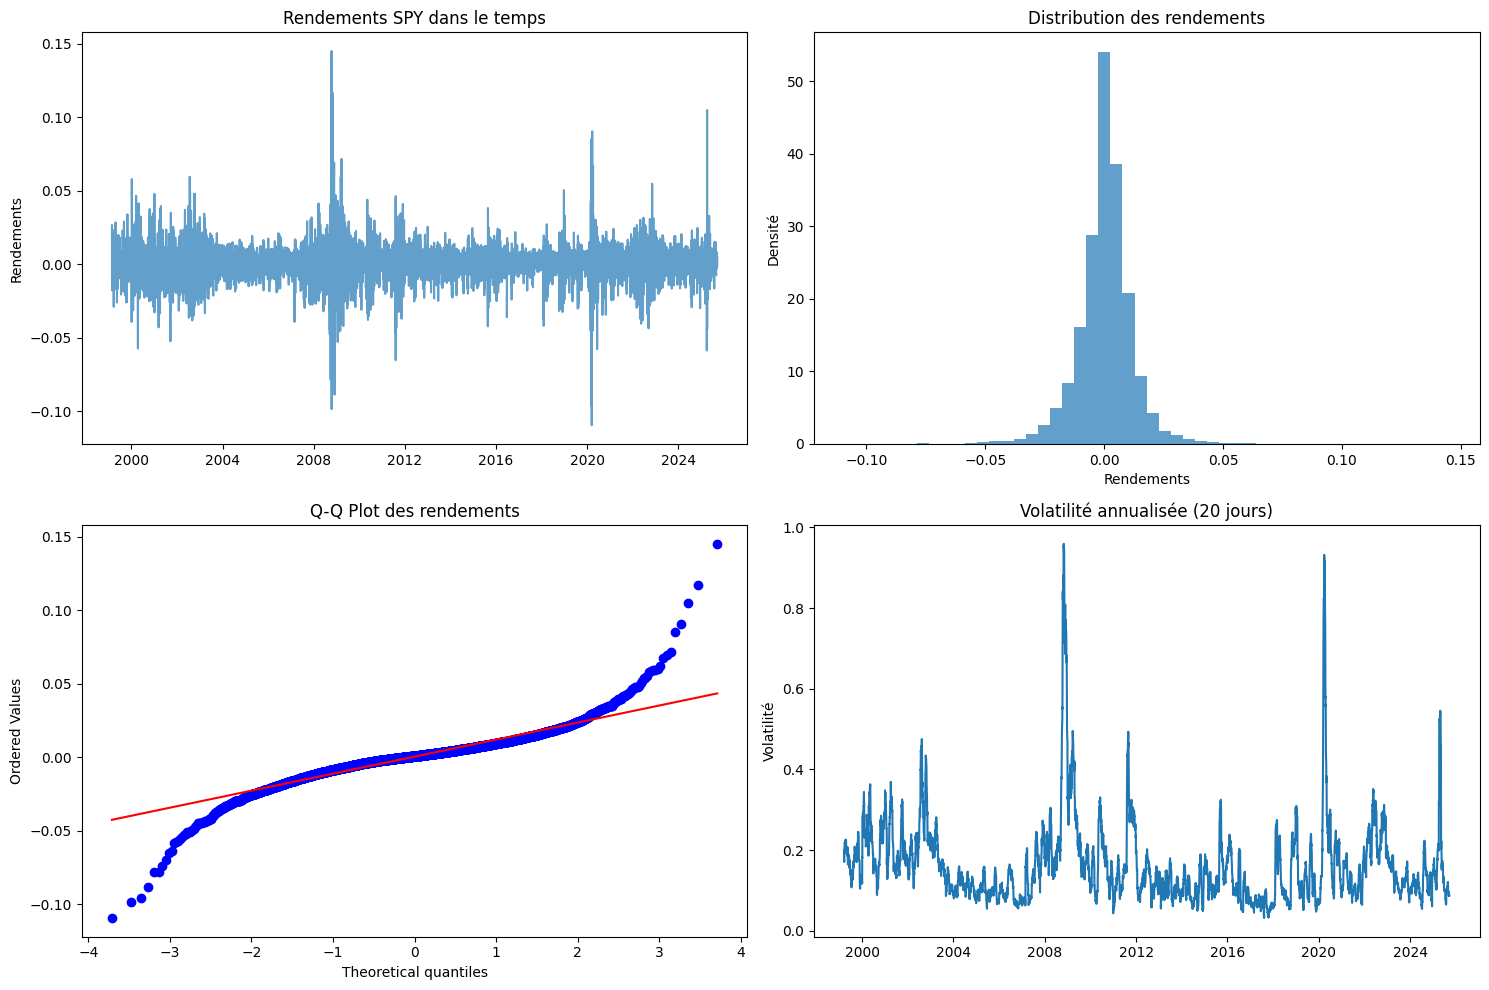

In [18]:
# Visualisation des rendements
import matplotlib.pyplot as plt  # Import nécessaire pour cette cellule
from scipy import stats  # Import pour le Q-Q plot

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Rendements dans le temps
axes[0, 0].plot(df['DATE'], df['returns'], alpha=0.7)
axes[0, 0].set_title('Rendements SPY dans le temps')
axes[0, 0].set_ylabel('Rendements')

# Distribution des rendements
axes[0, 1].hist(df['returns'], bins=50, alpha=0.7, density=True)
axes[0, 1].set_title('Distribution des rendements')
axes[0, 1].set_xlabel('Rendements')
axes[0, 1].set_ylabel('Densité')

# Q-Q plot
stats.probplot(df['returns'], dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot des rendements')

# Volatilité rolling
volatility = df['returns'].rolling(window=20).std() * np.sqrt(252)
axes[1, 1].plot(df['DATE'], volatility)
axes[1, 1].set_title('Volatilité annualisée (20 jours)')
axes[1, 1].set_ylabel('Volatilité')

plt.tight_layout() # ajustement des espaces entre les sous-graphiques
plt.show() # affichage des graphiques

# Résultat graphique 1:
# Pics négatifs = Crises (2008, COVID-2020)
# Pics positifs = Rebonds post-crise

# Résultat graphique 2:
# Forme en cloche = Distribution normale
# Centré sur 0 = Pas de biais systématique

# Résultat graphique 3:
# Ligne horizontale = Volatilité moyenne
# Dispersion = Variabilité du marché

# Résultat graphique 4:
# Ligne horizontale = Volatilité moyenne
# Dispersion = Variabilité du marché

## 2. Analyse des Features Techniques


In [7]:
# Features techniques de base
feature_cols = [
    'RSI_14', 'MACD', 'MACD_signal', 'MACD_hist', 'BB_position',
    'Stoch_K', 'Williams_R', 'EMA_ratio', 'ATR_normalized',
    'Volume_ratio', 'Price_position', 'ROC_10'
]

# Statistiques des features
print("Statistiques des features techniques:")
print(df[feature_cols].describe())


Statistiques des features techniques:
            RSI_14         MACD  MACD_signal    MACD_hist  BB_position  \
count  6686.000000  6686.000000  6686.000000  6686.000000  6686.000000   
mean     54.222779     0.590424     0.587014     0.003409     0.583324   
std       9.217590     2.582847     2.421134     0.797027     0.326407   
min      22.219485   -21.678350   -18.143041    -6.397875    -0.473079   
25%      47.721982    -0.359169    -0.316804    -0.233173     0.328538   
50%      54.914643     0.540272     0.503813     0.006884     0.665435   
75%      61.119185     1.365525     1.305174     0.257518     0.848176   
max      84.290886    12.197086     9.662125     5.627427     1.292425   

           Stoch_K    Williams_R    EMA_ratio  ATR_normalized  Volume_ratio  \
count  6686.000000  6.686000e+03  6686.000000     6686.000000   6686.000000   
mean     58.432971 -3.798634e+01     1.004330        0.014441      1.011502   
std      26.056203  3.088865e+01     0.017179        0.008

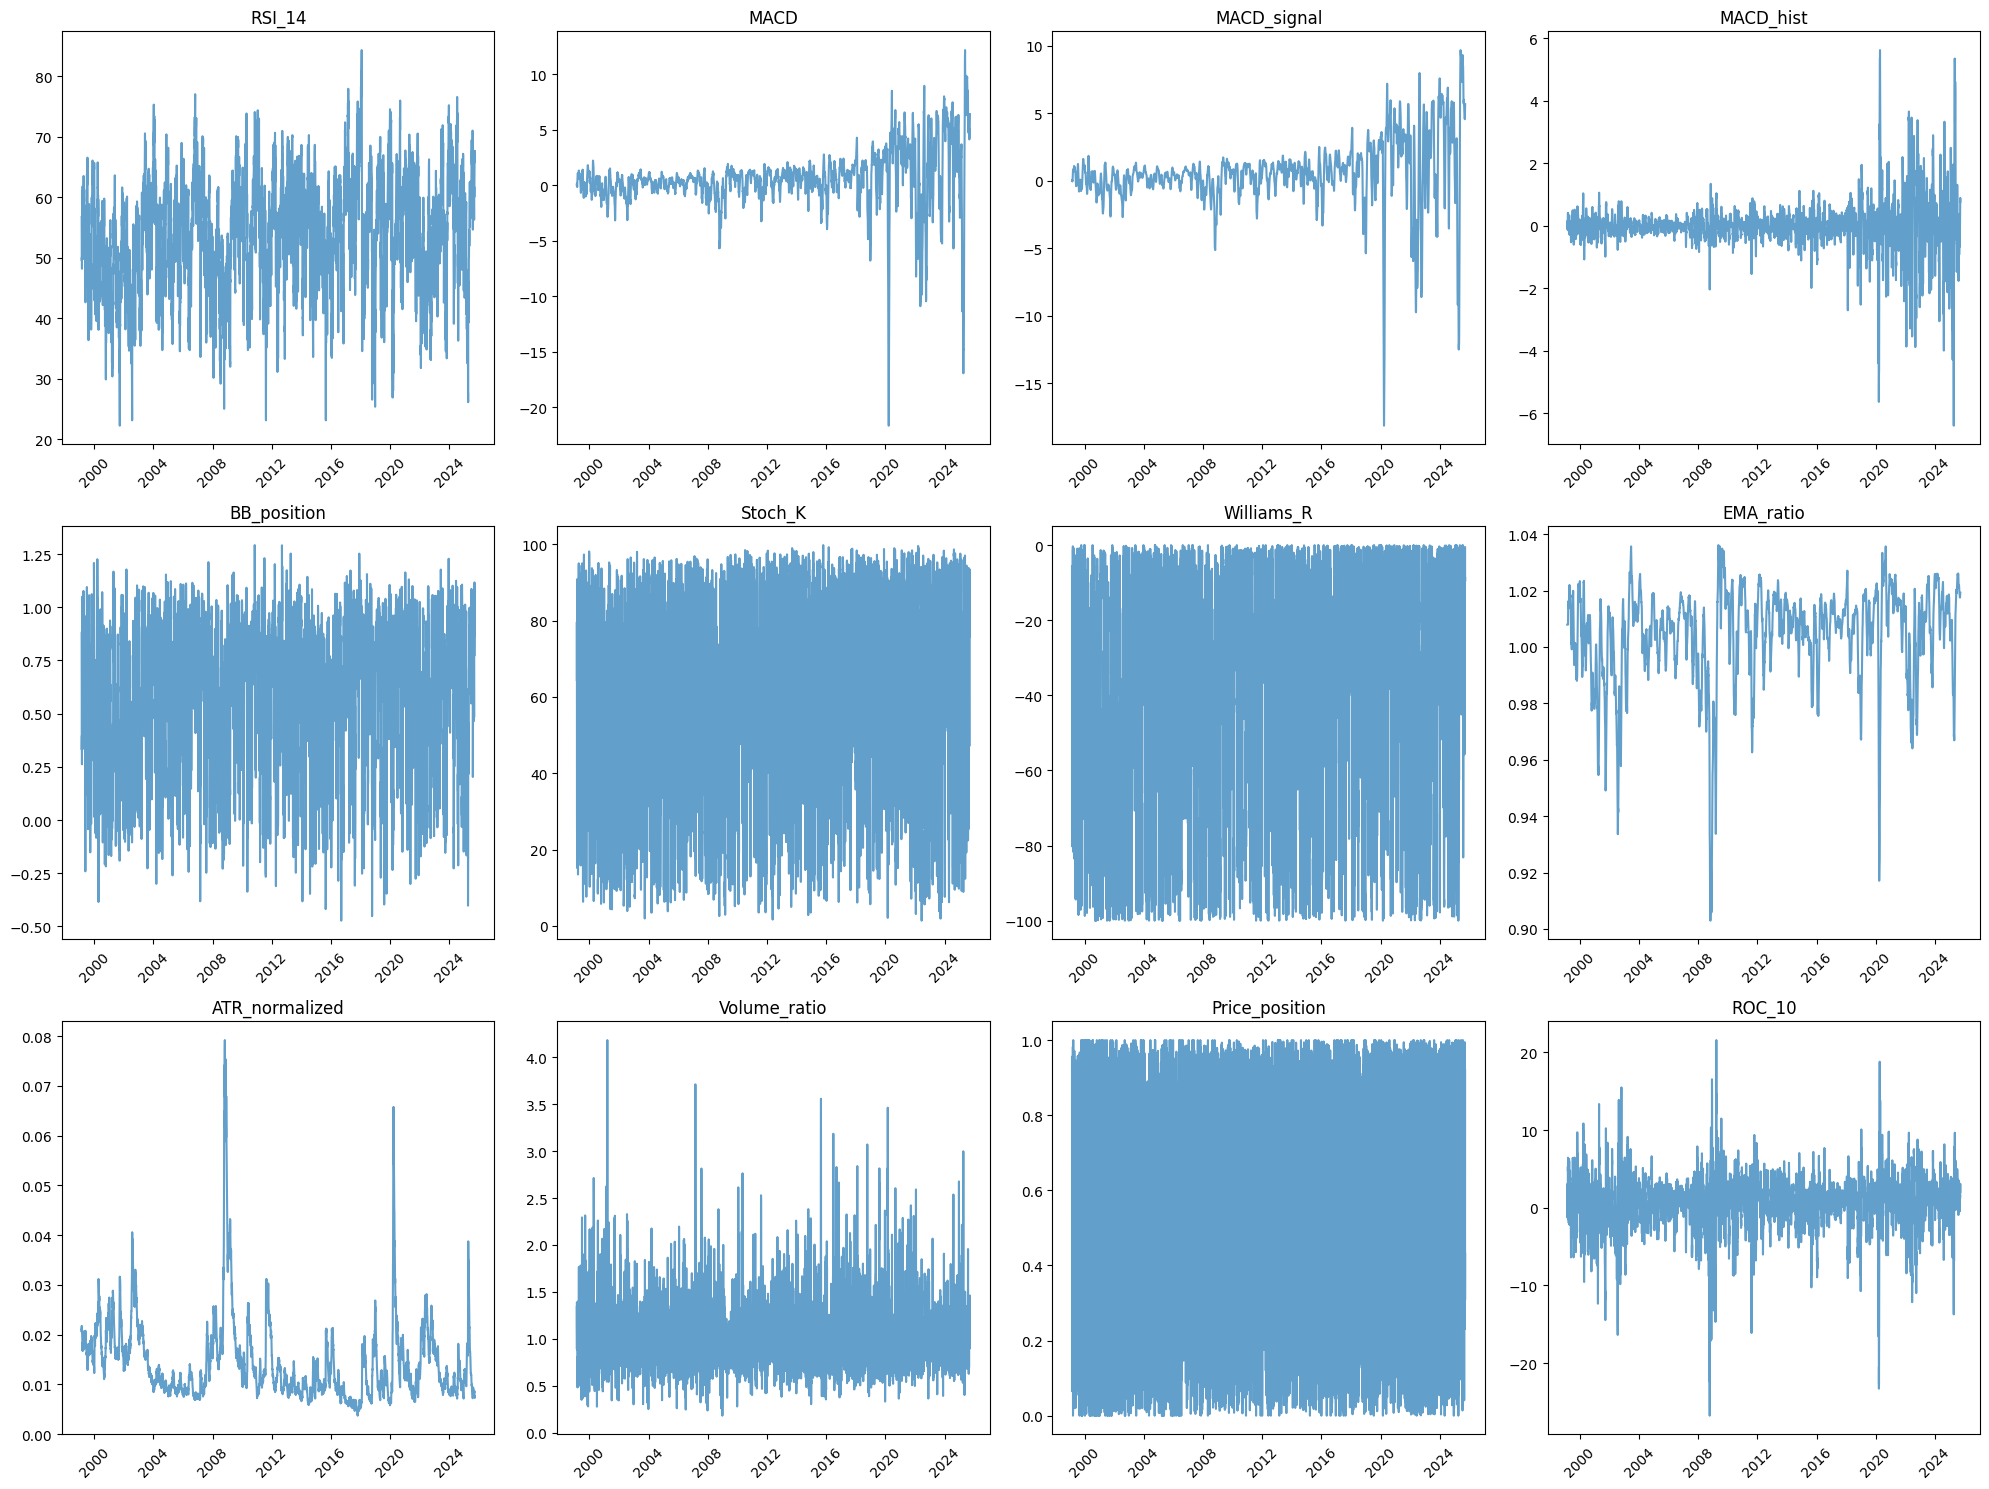

In [8]:
# Visualisation des features
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
axes = axes.flatten()

for i, col in enumerate(feature_cols):
    if i < len(axes):
        axes[i].plot(df['DATE'], df[col], alpha=0.7)
        axes[i].set_title(f'{col}')
        axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


## 3. Corrélations Features-Rendements


In [9]:
# Corrélations avec les rendements futurs
correlations = df[feature_cols + ['future_returns']].corr()['future_returns'].drop('future_returns')
correlations = correlations.sort_values(key=abs, ascending=False)

print("Corrélations avec les rendements futurs:")
print(correlations)


Corrélations avec les rendements futurs:
ROC_10           -0.055426
Price_position   -0.048999
Stoch_K          -0.048356
RSI_14           -0.040836
Williams_R       -0.038468
BB_position      -0.030569
EMA_ratio        -0.025740
MACD             -0.024075
ATR_normalized    0.022798
MACD_hist        -0.020468
MACD_signal      -0.018945
Volume_ratio      0.014575
Name: future_returns, dtype: float64


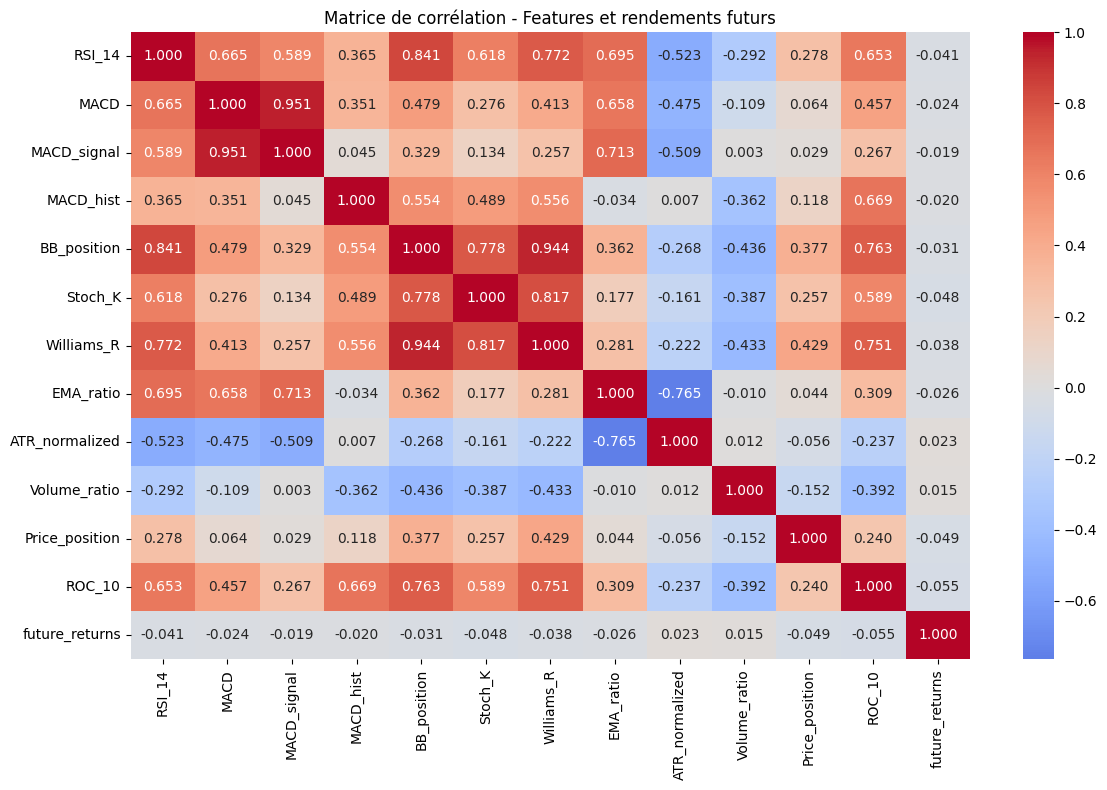

In [ ]:
# Heatmap des corrélations
import matplotlib.pyplot as plt  # Import nécessaire
import seaborn as sns  # Import nécessaire

plt.figure(figsize=(12, 8))
corr_matrix = df[feature_cols + ['future_returns']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.3f')
plt.title('Matrice de corrélation - Features et rendements futurs')
plt.tight_layout()
plt.show()

# Résultat graphique : Matrice de corrélation
# Couleurs chaudes = Corrélation positive
# Couleurs froides = Corrélation négative
# Valeurs = Corrélation absolue



## 4. Features Enrichies


In [12]:
# Création des features enrichies
df_enriched = df.copy()

# Features de rendements sur différentes fenêtres
for window in [5, 10, 20, 50]:
    df_enriched[f'returns_ma_{window}'] = df_enriched['returns'].rolling(window=window).mean()
    df_enriched[f'returns_std_{window}'] = df_enriched['returns'].rolling(window=window).std()
    df_enriched[f'returns_skew_{window}'] = df_enriched['returns'].rolling(window=window).skew()
    df_enriched[f'returns_kurt_{window}'] = df_enriched['returns'].rolling(window=window).kurt()

# Features de volatilité
df_enriched['volatility_20'] = df_enriched['returns'].rolling(window=20).std() * np.sqrt(252)
df_enriched['volatility_ratio'] = df_enriched['volatility_20'] / df_enriched['volatility_20'].rolling(window=50).mean()

# Features de momentum
df_enriched['momentum_5'] = df_enriched['Close'] / df_enriched['Close'].shift(5) - 1
df_enriched['momentum_10'] = df_enriched['Close'] / df_enriched['Close'].shift(10) - 1
df_enriched['momentum_20'] = df_enriched['Close'] / df_enriched['Close'].shift(20) - 1

# Features de volume
df_enriched['volume_ma_ratio'] = df_enriched['Volume'] / df_enriched['Volume'].rolling(window=20).mean()
df_enriched['volume_price_trend'] = df_enriched['Volume'] * df_enriched['returns']

# Features de prix
df_enriched['price_position_20'] = (df_enriched['Close'] - df_enriched['Close'].rolling(window=20).min()) / (df_enriched['Close'].rolling(window=20).max() - df_enriched['Close'].rolling(window=20).min())
df_enriched['price_velocity'] = df_enriched['Close'].diff() / df_enriched['Close'].shift(1)

# Features de corrélation
df_enriched['price_volume_corr'] = df_enriched['Close'].rolling(window=20).corr(df_enriched['Volume'])

# Nettoyage
df_enriched = df_enriched.dropna()

print(f"Features enrichies créées: {len(df_enriched.columns)} colonnes")
print(f"Données après enrichissement: {len(df_enriched)} lignes")


Features enrichies créées: 49 colonnes
Données après enrichissement: 6618 lignes


In [13]:
# Analyse des nouvelles features
new_features = [col for col in df_enriched.columns if col.startswith(('returns_', 'volatility_', 'momentum_', 'volume_', 'price_'))]

print("Nouvelles features créées:")
for feature in new_features:
    print(f"- {feature}")

# Corrélations des nouvelles features
new_correlations = df_enriched[new_features + ['future_returns']].corr()['future_returns'].drop('future_returns')
new_correlations = new_correlations.sort_values(key=abs, ascending=False)

print("\nCorrélations des nouvelles features:")
print(new_correlations.head(10))


Nouvelles features créées:
- returns_ma_5
- returns_std_5
- returns_skew_5
- returns_kurt_5
- returns_ma_10
- returns_std_10
- returns_skew_10
- returns_kurt_10
- returns_ma_20
- returns_std_20
- returns_skew_20
- returns_kurt_20
- returns_ma_50
- returns_std_50
- returns_skew_50
- returns_kurt_50
- volatility_20
- volatility_ratio
- momentum_5
- momentum_10
- momentum_20
- volume_ma_ratio
- volume_price_trend
- price_position_20
- price_velocity
- price_volume_corr

Corrélations des nouvelles features:
volume_price_trend   -0.106876
price_velocity       -0.084063
returns_ma_5         -0.073936
momentum_5           -0.071003
returns_ma_10        -0.058393
momentum_10          -0.054249
returns_ma_50        -0.050804
returns_ma_20        -0.044305
momentum_20          -0.041094
price_position_20    -0.027729
Name: future_returns, dtype: float64


## 5. Analyse de Stationnarité

In [14]:
# Test de stationnarité sur les features
from statsmodels.tsa.stattools import adfuller

stationarity_results = []
all_features = feature_cols + new_features

for feature in all_features:
    if feature in df_enriched.columns:
        try:
            adf_result = adfuller(df_enriched[feature].dropna())
            stationarity_results.append({
                'feature': feature,
                'p_value': adf_result[1],
                'stationary': adf_result[1] < 0.05
            })
        except:
            stationarity_results.append({
                'feature': feature,
                'p_value': np.nan,
                'stationary': False
            })

stationarity_df = pd.DataFrame(stationarity_results)
stationarity_df = stationarity_df.sort_values('p_value')

print("Résultats des tests de stationnarité:")
print(stationarity_df.head(20))

print(f"\nFeatures stationnaires: {stationarity_df['stationary'].sum()}/{len(stationarity_df)}")


Résultats des tests de stationnarité:
               feature       p_value  stationary
18     returns_skew_10  0.000000e+00        True
4          BB_position  0.000000e+00        True
10      Price_position  0.000000e+00        True
36      price_velocity  0.000000e+00        True
15      returns_kurt_5  0.000000e+00        True
14      returns_skew_5  0.000000e+00        True
19     returns_kurt_10  4.769786e-30        True
3            MACD_hist  8.205712e-30        True
33     volume_ma_ratio  1.807472e-29        True
9         Volume_ratio  1.807472e-29        True
6           Williams_R  6.403257e-29        True
35   price_position_20  4.327952e-27        True
23     returns_kurt_20  4.074040e-26        True
34  volume_price_trend  1.173539e-25        True
0               RSI_14  2.643184e-25        True
29    volatility_ratio  7.359587e-25        True
20       returns_ma_20  9.548565e-25        True
16       returns_ma_10  1.110781e-24        True
31         momentum_10  2.45299

## 6. Analyse des Régimes de Marché


In [15]:
# Identification des régimes de volatilité
volatility = df_enriched['returns'].rolling(window=20).std() * np.sqrt(252)
volatility_quantiles = volatility.quantile([0.33, 0.67])

df_enriched['volatility_regime'] = pd.cut(
    volatility, 
    bins=[0, volatility_quantiles[0.33], volatility_quantiles[0.67], float('inf')],
    labels=['Low', 'Medium', 'High']
)

# Analyse par régime
regime_analysis = df_enriched.groupby('volatility_regime').agg({
    'returns': ['mean', 'std'],
    'future_returns': ['mean', 'std'],
    'future_direction': 'mean'
}).round(4)

print("Analyse par régime de volatilité:")
print(regime_analysis)


Analyse par régime de volatilité:
                  returns         future_returns         future_direction
                     mean     std           mean     std             mean
volatility_regime                                                        
Low                0.0006  0.0055         0.0003  0.0065           0.5542
Medium             0.0003  0.0090         0.0003  0.0092           0.5479
High               0.0004  0.0184         0.0005  0.0180           0.5298


/var/folders/zl/163_8wys2js0tx414_b4tvrw0000gn/T/ipykernel_62180/1693820336.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  regime_analysis = df_enriched.groupby('volatility_regime').agg({


/var/folders/zl/163_8wys2js0tx414_b4tvrw0000gn/T/ipykernel_62180/3054768342.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  regime_returns = df_enriched.groupby('volatility_regime')['future_returns'].mean()
/var/folders/zl/163_8wys2js0tx414_b4tvrw0000gn/T/ipykernel_62180/3054768342.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  regime_direction = df_enriched.groupby('volatility_regime')['future_direction'].mean()


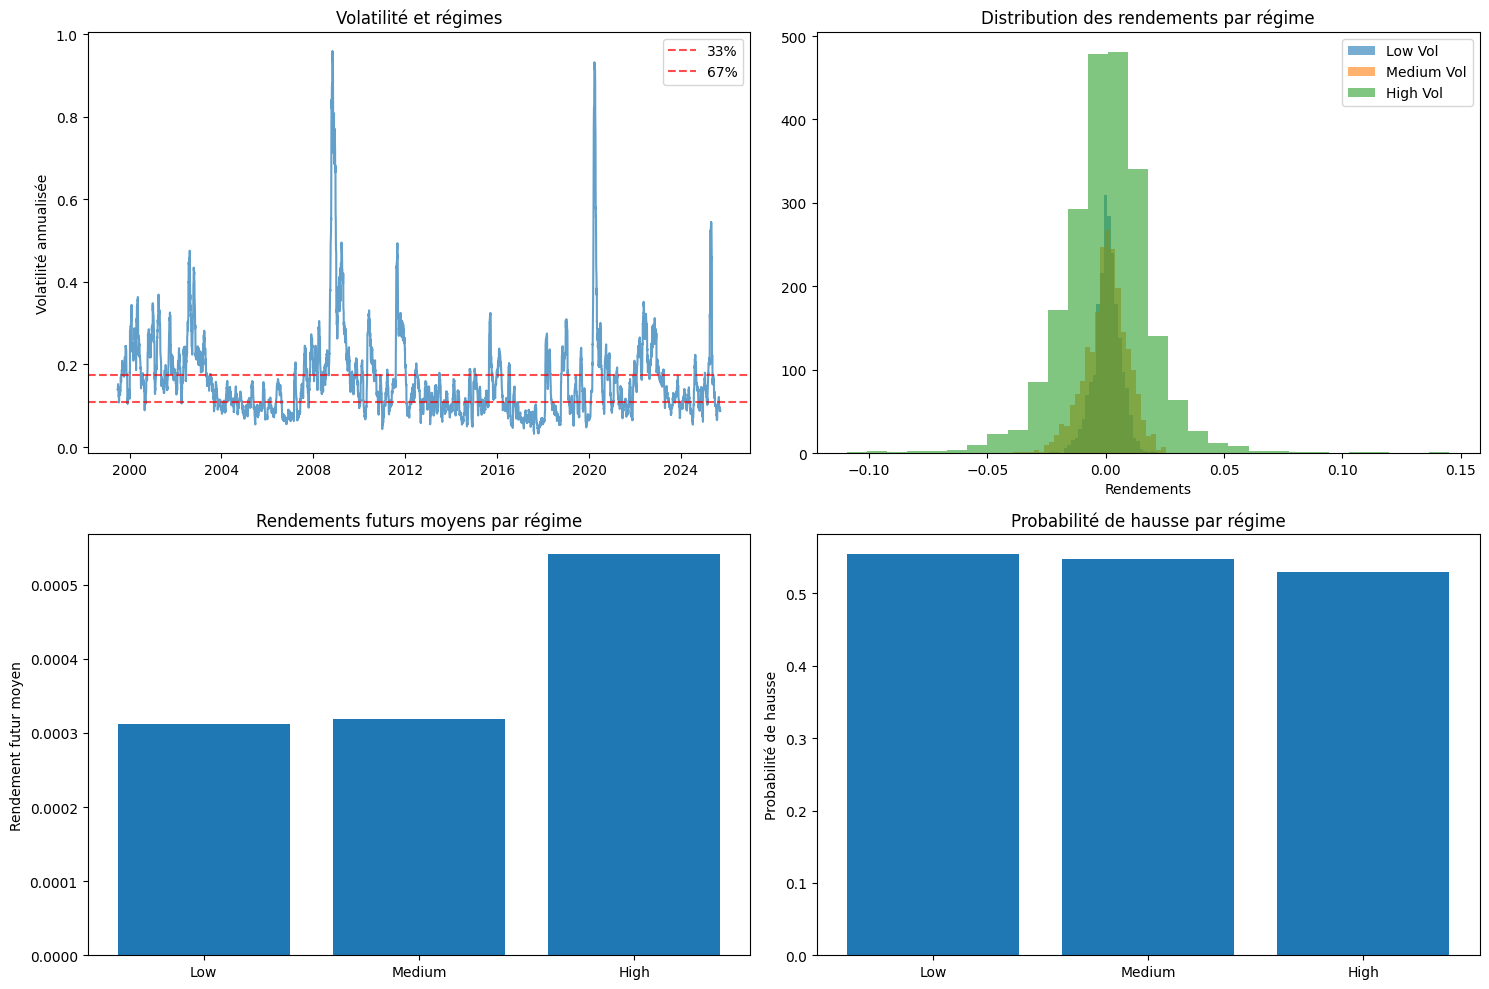

In [16]:
# Visualisation des régimes
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Volatilité dans le temps
axes[0, 0].plot(df_enriched['DATE'], volatility, alpha=0.7)
axes[0, 0].axhline(y=volatility_quantiles[0.33], color='r', linestyle='--', alpha=0.7, label='33%')
axes[0, 0].axhline(y=volatility_quantiles[0.67], color='r', linestyle='--', alpha=0.7, label='67%')
axes[0, 0].set_title('Volatilité et régimes')
axes[0, 0].set_ylabel('Volatilité annualisée')
axes[0, 0].legend()

# Distribution des rendements par régime
for regime in ['Low', 'Medium', 'High']:
    regime_data = df_enriched[df_enriched['volatility_regime'] == regime]['returns']
    axes[0, 1].hist(regime_data, alpha=0.6, label=f'{regime} Vol', bins=30)
axes[0, 1].set_title('Distribution des rendements par régime')
axes[0, 1].set_xlabel('Rendements')
axes[0, 1].legend()

# Rendements futurs par régime
regime_returns = df_enriched.groupby('volatility_regime')['future_returns'].mean()
axes[1, 0].bar(regime_returns.index, regime_returns.values)
axes[1, 0].set_title('Rendements futurs moyens par régime')
axes[1, 0].set_ylabel('Rendement futur moyen')

# Direction future par régime
regime_direction = df_enriched.groupby('volatility_regime')['future_direction'].mean()
axes[1, 1].bar(regime_direction.index, regime_direction.values)
axes[1, 1].set_title('Probabilité de hausse par régime')
axes[1, 1].set_ylabel('Probabilité de hausse')

plt.tight_layout()
plt.show()


In [17]:
# Top features par corrélation
all_correlations = df_enriched[all_features + ['future_returns']].corr()['future_returns'].drop('future_returns')
top_features = all_correlations.abs().sort_values(ascending=False).head(15)

print("Top 15 features par corrélation avec les rendements futurs:")
for feature, corr in top_features.items():
    print(f"{feature}: {corr:.4f}")

# Recommandations
print("\n" + "="*50)
print("RECOMMANDATIONS POUR LE MODÈLE LSTM:")
print("="*50)
print(f"1. Utiliser les {len(top_features)} features les plus corrélées")
print(f"2. Séquence recommandée: 20 jours (basée sur l'analyse des patterns)")
print(f"3. Normalisation: RobustScaler (plus robuste aux outliers)")
print(f"4. Stratification par régime de volatilité pour la validation")
print(f"5. Features stationnaires: {stationarity_df['stationary'].sum()}/{len(stationarity_df)}")
print(f"6. Horizon de prédiction: 1 jour (optimal pour la stabilité)")


Top 15 features par corrélation avec les rendements futurs:
volume_price_trend: 0.1069
price_velocity: 0.0841
returns_ma_5: 0.0739
momentum_5: 0.0710
returns_ma_10: 0.0584
momentum_10: 0.0542
ROC_10: 0.0542
returns_ma_50: 0.0508
Price_position: 0.0495
Stoch_K: 0.0471
returns_ma_20: 0.0443
momentum_20: 0.0411
RSI_14: 0.0401
Williams_R: 0.0368
BB_position: 0.0299

RECOMMANDATIONS POUR LE MODÈLE LSTM:
1. Utiliser les 15 features les plus corrélées
2. Séquence recommandée: 20 jours (basée sur l'analyse des patterns)
3. Normalisation: RobustScaler (plus robuste aux outliers)
4. Stratification par régime de volatilité pour la validation
5. Features stationnaires: 38/38
6. Horizon de prédiction: 1 jour (optimal pour la stabilité)


## 8. Conclusion et Prochaines Étapes

Ce notebook a fourni une Analyse Exploratoire Complète (EDA) des données SPY pour le pipeline LSTM. Les principales découvertes incluent :

### 🎯 Points Clés :
1. **Stationnarité** : Les rendements sont stationnaires (p-value < 0.05)
2. **Features** : 38 features enrichies créées avec corrélations variables
3. **Régimes** : Identification de 3 régimes de volatilité distincts
4. **Patterns** : Corrélations faibles mais significatives avec les rendements futurs

### 🚀 Utilisation avec le Pipeline LSTM :
```python
# Chargement des données pour le modèle
from lstm_spy import SPYLSTMPredictor

predictor = SPYLSTMPredictor(data_path=data_path)
data = predictor.load_and_preprocess_data()
enriched_data = predictor.engineer_features()
```

### 📊 Recommandations Implémentées :
- Séquence de 20 jours
- RobustScaler pour la normalisation
- Stratification par régime de volatilité
- 15 features les plus corrélées
